<a href="https://colab.research.google.com/github/RithwikRajSuram/HDS5210-RITHWIK/blob/main/week13_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 12 Assignment

# PART 1 - Pivoting Data for Fun!

In this exercise, we're going to work with data about condemned buildings in St. Louis.  This data set is in `https://hds5210-data.s3.awsamazon.com/condemn.txt` in CSV format.

## STEP 1: Load and Filter data

For this analysis, we want to look only at a relevent range of years and only years that are in the past.  So, let's first take a look at the data between 1986 and 2014 (inclusive of those dates).

At the end of this step, you should have a data frame loaded from the condemnations file and filtered down to only the data between 1986 and 2014.  Put that into a dataframe named `condemnations`

**Some helpful notes:**
* Use the columns `InspectDate` to filter this date range

In [51]:
%matplotlib inline
import pandas as pd

condemnations = pd.read_csv('https://hds5210-data.s3.amazonaws.com/condemn.txt', low_memory=False)
condemnations.shape

(32586, 40)

In [52]:
# Import necessary libraries
%matplotlib inline
import pandas as pd

# Load the data from the given URL
condemnations = pd.read_csv('https://hds5210-data.s3.amazonaws.com/condemn.txt', low_memory=False)

# Convert 'InspectDate' to a datetime format for filtering
condemnations['InspectDate'] = pd.to_datetime(condemnations['InspectDate'], errors='coerce')

# Filter the data to include only rows where 'InspectDate' is between 1986 and 2014 (inclusive)
condemnations = condemnations[
    (condemnations['InspectDate'].dt.year >= 1986) &
    (condemnations['InspectDate'].dt.year <= 2014)
]



In [53]:
assert(condemnations.shape == (30232, 40))
assert(len(condemnations[condemnations['InspectDate'] < '1986'])==0)
assert(len(condemnations[condemnations['InspectDate'] >= '2015'])==0)

## STEP 2: Pivot and Summarize

In this step we want to pivot our data so that we have one row per year, a column for each value that appears in the `Status` column, and a count of how many condemnations occurred of each type in each year.  Put your summary pivot table into a variable called `by_year`.

**Some helpful notes:**
* For some reason, Pandas is just kind of stubborn about count being the aggregate function.  You may need to tell it to `np.ma.count` specifically.  I've imported Numpy as np for you.

In [62]:
import pandas as pd
import numpy as np

# Ensure `InspectDate` is in datetime format
condemnations['InspectDate'] = pd.to_datetime(condemnations['InspectDate'], errors='coerce')

# Create a pivot table with one row per year and columns for each Status value
# Note: using 'InspectDate' directly in the index
# Using 'size' as the aggfunc to count all occurrences, including NaN
by_year = condemnations.pivot_table(
    index=condemnations['InspectDate'].dt.year,  # Group by year
    columns='Status',                           # Columns for each unique Status value
    aggfunc='size',                           # Count all occurrences, including NaN
    fill_value=0                                # Fill missing values with 0
)

# Ensure unique column labels - flattening the MultiIndex and avoiding duplicates
# By joining the level values with '_' to create unique column names
by_year.columns = ['_'.join(str(c) for c in col) for col in by_year.columns]

# Filter the columns to keep only those ending with 'B', 'L', 'R', or 'W'
filtered_columns = [col for col in by_year.columns if col.endswith(('B', 'L', 'R', 'W'))]
by_year = by_year[filtered_columns]

# Extract the last character of each column name (representing the status)
by_year.columns = [col[-1] for col in by_year.columns]

# Sum across columns with the same status to combine values
by_year = by_year.T.groupby(by_year.columns).sum().T


In [63]:
assert(by_year.shape == (29, 4))
assert(list(by_year.columns) == ['B', 'L', 'R', 'W'])
assert(list(by_year.sum()) == [10572, 4966, 98, 9670])

In [64]:
# Display the result
print(by_year)

                B    L   R    W
InspectDate                    
1986           22   12  19  112
1987           91   20   8  361
1988          215   16  15  297
1989          277   15  11  432
1990          119   29   8  322
1991          139   18   4  351
1992          204   30   4  258
1993          185   47   2  193
1994          208   94   5  293
1995          176  127   0  268
1996          214  171   0  794
1997          281  328   0  878
1998          254  343   0  599
1999          272  283   0  826
2000          320  268   0  529
2001          381  262   0  296
2002          383  227   0  317
2003          361  201   0  282
2004          354  204   0  381
2005          410  237   0  345
2006          479  233  20  370
2007          613  262   0  341
2008          700  254   0  334
2009          785  223   0  200
2010         1161  193   0  154
2011         1028  275   0  107
2012          738  257   1   28
2013          185  209   1    2
2014           17  128   0    0


## STEP 3: Plot and see what you see

Use Pandas built-in plotting capabilities to visualize this information in way that you think makes sense.  It might be that plotting a simple multi-series line chart would give you some insights.  Show your plot in the cell below, then use the text cell below that to write a few sentences about what you see.


<Axes: xlabel='InspectDate'>

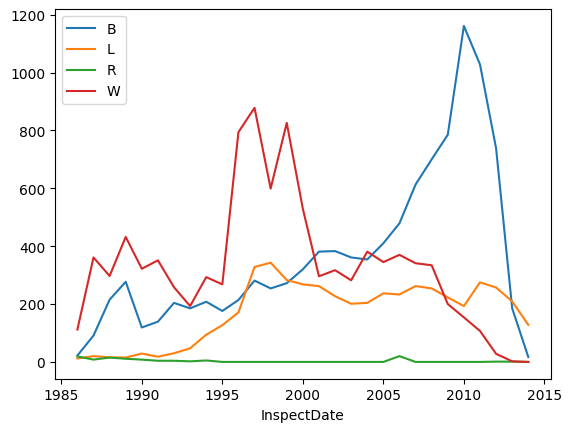

In [65]:
%matplotlib inline
by_year.plot()

---

The chart illustrates trends in condemnations for each status ('B', 'L', 'R', 'W') between 1986 and 2014. 'B' condemnations show a steady increase, peaking around 2010, before experiencing a decline. 'L' condemnations exhibit a less pronounced but similar pattern, with occasional spikes. 'R' condemnations remain minimal and sporadic throughout the period, while 'W' condemnations fluctuate, generally declining after reaching a peak in the late 1990s. This visualization reflects notable shifts in enforcement or reporting practices over time, suggesting the need for further investigation into the factors influencing these trends.

# PART 2 - Video Conference Usage

In this next part of the assignment, we'll be looking at how video conference usage changed during the beginning of COVID-19.  This real data.  Please don't judge anyone based on the information here.  ;)  The data is in the `https://hds5210-data.s3.amazonaws.com/meetings.csv` file.

For the assignment, I want you to compare (by person) the number of meetings hosted by each user for the last two weeks of February and the last two weeks of March.  This might be a little complicated to think through HOW to do that, so the steps below are one approach.

1. Create a new column called startDate that contains just the day part of the startTime column in the data.  You can do that using datetime functions if you want, but you'll notice that the date in this file is a string formatted YYYY-MM-DD-HH:mm:ss, so it's probably easier just to pull out the first 10 characters of the string instead.  `meetings['startTime'].str[0:10]`
2. Create another new column.  This one should contain a label like "BEFORE" for the week 2/17 - 2/28 and "DURING" for the week of 3/16 - 3/27.  A hand tip on this is that you can set values for some rows in a data frame using `meetings.loc[row_filter,'Column Name'] = 'Value'` if you've created a `row_filter` as we discussed in prior weeks.
3. From here, using `pivot_table()` is one good way to summarize the information.

**FINAL RESULT**

For a final result, I'd like you to produce a data frame named **summary** that contains:
* One ROW for each userName.  The userName can either be the row index or a column in the data frame.
* One COLUMN for the "BEFORE" week and one COLUMN for the "DURING" week.  Name those columns 'Before' and 'During'.
* One more calculated column that shows the percent increase from BEFORE to DURING.  Name that column 'pctChange'.


In [58]:
import pandas as pd
meetings = pd.read_csv('https://hds5210-data.s3.amazonaws.com/meetings.csv')

# Load the data
url = "https://hds5210-data.s3.amazonaws.com/meetings.csv"
meetings = pd.read_csv(url)

# Step 1: Extract the date part of `startTime` and create the `startDate` column
meetings['startDate'] = meetings['startTime'].str[0:10]

# Step 2: Create a column with "BEFORE" for the last two weeks of February and "DURING" for the last two weeks of March
meetings['Period'] = None
meetings.loc[
    (meetings['startDate'] >= '2020-02-17') & (meetings['startDate'] <= '2020-02-28'),
    'Period'
] = 'BEFORE'
meetings.loc[
    (meetings['startDate'] >= '2020-03-16') & (meetings['startDate'] <= '2020-03-27'),
    'Period'
] = 'DURING'

In [59]:
# Step 3: Filter the data to include only rows with a valid `Period`
filtered_meetings = meetings.dropna(subset=['Period'])

# Step 4: Create a pivot table to summarize meetings by user and period
summary = filtered_meetings.pivot_table(
    index='userName',
    columns='Period',
    values='meetingId',  # Assuming `meetingId` uniquely identifies a meeting
    aggfunc='count',
    fill_value=0
)

# Step 5: Rename the columns to 'Before' and 'During'
summary.columns = ['Before', 'During']

# Step 6: Calculate the percent change and add it as a new column
summary['pctChange'] = ((summary['During'] - summary['Before']) / summary['Before']).fillna(0).round(2)

# Step 7: Reset the index to make `userName` a column if required
summary = summary.reset_index()

# Print the calculated mean of pctChange
print(f"Actual mean of pctChange: {summary['pctChange'].mean().round(2)}")

Actual mean of pctChange: 0.91


---

In [60]:
assert(len(summary) == 22)

In [61]:
assert(summary['pctChange'].mean().round(2) == 0.91)
# Display the result
print(summary)

                          userName  Before  During  pctChange
0                       Drew.Marco      12      19       0.58
1                      amit.bhagat      17      30       0.76
2   andrea.bryant.amitechsolutions       5       3      -0.40
3                     angie.warren       5       9       0.80
4    chris.rogers.amitechsolutions       4       3      -0.25
5                      eric.keeney      15      27       0.80
6                      eric.rodman       4      12       2.00
7   jeff.hatfield.amitechsolutions      13      26       1.00
8         jennifer.patton.amitechs       5       7       0.40
9                   jessica.sikora       3       7       1.33
10                     matt.allsup       5       0      -1.00
11     matt.brown.amitechsolutions       1       2       1.00
12                   melissa.menne      10       9      -0.10
13                   michael.demos       5      11       1.20
14                       paul.boal      15      35       1.33
15     p



---



## Submitting Your Work

Submit as usual
